In [1]:
from lib import filedb
import pandas as pd
import os.path
import numpy as np
from lib import strainmap
#from figures.figure_63x_sigb_histo import subfig_indivfile_histo
from lib.analysis.sigb_histograms import make_indivfile_histogram
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import scipy.stats

In [8]:
from lib.analysis.sliding_windows import sliding_window_indivfiles, sliding_window_errors #sliding_window_distribution

In [4]:
from lib.figure_util import strain_color
from lib import figure_util

basedir = "../datasets/LSM700_63x_sigb"

cell_df = pd.read_hdf(os.path.join(basedir, "single_cell_data.h5"), "cells")
file_df = filedb.get_filedb(os.path.join(basedir, "file_list.tsv"))

In [10]:
cell_df["ratio"] = cell_df["green_raw_bg_mean"]/cell_df["red_raw_bg_mean"]


In [6]:
strain_map, des_strain_map = strainmap.load()

## Whats going on in 2xQP at 24 hours

In [12]:
fids = file_df[(file_df["time"] == 24) &
                (file_df["location"] == "center") &
                (file_df["strain"] == des_strain_map["2xqp_sigar_sigby"])].index
strain_df = cell_df[cell_df["global_file_id"].isin(fids)]

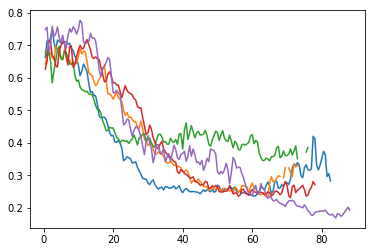

In [21]:
fig, ax = plt.subplots(1,1)  
distance, results, fileids = sliding_window_indivfiles(strain_df, (0, 150, 0.5), 1, "ratio")
for f, fid in enumerate(fileids):
    ax.plot(distance,results["mean"][f,:], label=str(fid) )


In [20]:
def sliding_window_indivfiles(cell_df, depth_info, window_width, channel, cut):
    (min_d, max_d, step) = depth_info
    rad = window_width/2
    distances = np.arange(min_d + rad, max_d-rad, step)
    slider = [ (d-rad, d+rad) for d in distances]
    keys = [("mean", np.nanmean)] #,  ("std", np.std), ("sem", lambda x: x.sem() ) ]
    #print(cell_df.columns)
    fileids = cell_df["global_file_id"].unique()
    
    results = { k: np.zeros((len(fileids), len(distances))) for k, _ in keys}

    for f, fid in enumerate(fileids):
        filedf = cell_df[cell_df["global_file_id"] == fid]
        for i, (sd, ed) in enumerate(slider):
            cut_df = filedf[(filedf["distance"]>sd) & (filedf["distance"]<=ed)] 
            for k, func in keys:
                if len(cut_df) > 20: 
                    results[k][f, i] = func(cut_df[channel].values)
                else:
                    results[k][f, i] = np.nan

    return distances, results, fileids